In [2]:
# Import libraries
from sklearn.model_selection import train_test_split, StratifiedKFold
import sys
sys.path.append("../src/features")
from FeatureSelectionOptuna import FeatureSelectionOptuna
import pandas as pd
from xgboost import XGBClassifier
import optuna
from optuna.samplers import TPESampler


pd.set_option('display.max_columns', 500)

df = pd.read_csv("../data/processed/all_shots-v6.csv", index_col=0)


df.loc[df['Shot Distance'] < 3, 'Shot Zone Range_Less Than 3 ft.'] = 1
df.loc[df['Shot Distance'] >= 3, 'Shot Zone Range_Less Than 3 ft.'] = 0

df.loc[df['Shot Distance'] == 15, 'Shot Zone Range_15'] = 1
df.loc[df['Shot Distance'] != 15, 'Shot Zone Range_15'] = 0


df_fs = df[['Shot Distance', 'X Location', 'Y Location', 'Season Type',
        'Shot Zone Basic_Above the Break 3', 'Shot Zone Basic_Backcourt', 'Shot Zone Basic_In The Paint (Non-RA)',
       'Shot Zone Basic_Left Corner 3', 'Shot Zone Basic_Mid-Range','Shot Zone Basic_Restricted Area', 'Shot Zone Basic_Right Corner 3',
       'Shot Zone Area_Center(C)', 'Shot Zone Area_Left Side Center(LC)', 'Shot Zone Area_Left Side(L)',
       'Shot Zone Area_Right Side Center(RC)', 'Shot Zone Area_Right Side(R)', 'Shot Zone Range_16-24 ft.', 'Shot Zone Range_24+ ft.',
       'Shot Zone Range_8-16 ft.', 'Shot Zone Range_Less Than 8 ft.', 'target', 'Shot Zone Range_15', 'Shot Zone Range_Less Than 3 ft.',
       'PERIOD', 'PLAYER1_NAME', 'at_home', 'PREVIOUS_OFF_REBOUND', 'PREVIOUS_DEF_REBOUND', 'dunk_shot',
       'PREVIOUS_OFF_TURNOVER', 'PREVIOUS_OFF_MISSED', 'DETAILLED_SHOT_TYPE',  'seconds_left', 'Age', 'TS%', 'PTM', 'ASTM', 'ORBM', 'STLM', 'BLKM', 'TOVM', 'USG%',
       'FG%', '2P%', '3P%', 'FT%', 'PTS', 'height', 'weight', 'C', 'PF', 'PG', 'PG-SG', 'SF', 'SF-SG', 'SG', 'SG-PG',
       'E_DEF_RATING', 'E_OFF_RATING', 'PCT_PREV_ACTION', 'PCT_AREA', 'YEARS_EXP']]

def update_shot_type(data):    
    data.loc[(data.DETAILLED_SHOT_TYPE != 'JUMP SHOT') & (data.DETAILLED_SHOT_TYPE != "FREE THROW"), 'DETAILLED_SHOT_TYPE'] = 'OTHER'
    return data

df_fs = update_shot_type(df_fs)

c:\Users\Sarah\anaconda3\envs\nba_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


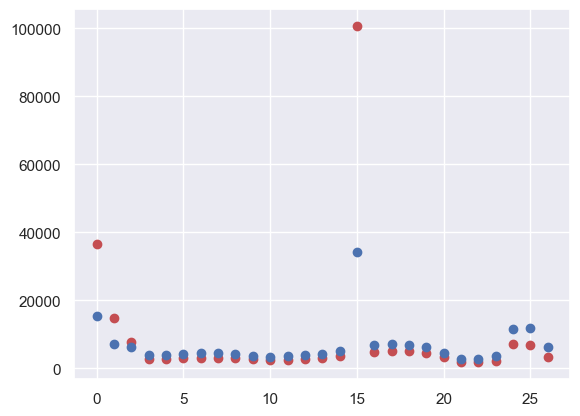

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme("notebook")
made = df_fs[(df_fs.target==1) & (df_fs['Shot Distance'] < 27)].groupby('Shot Distance').count()['target']
not_made = df_fs[(df_fs.target==0) & (df_fs['Shot Distance'] < 27)].groupby('Shot Distance').count()['target']
plt.scatter(made.index, made, color='r')
plt.scatter(not_made.index, not_made, color='b')

In [41]:
df_fs.loc[df_fs['Shot Distance'] < 3, 'Shot Zone Range_Less Than 3 ft.'] = 1
df_fs.loc[df_fs['Shot Distance'] >= 3, 'Shot Zone Range_Less Than 3 ft.'] = 0

df_fs.loc[df_fs['Shot Distance'] == 15, 'Shot Zone Range_15'] = 1
df_fs.loc[df_fs['Shot Distance'] != 15, 'Shot Zone Range_15'] = 0

In [4]:
SEED = 32

X = df_fs.drop(['target', 'PLAYER1_NAME'], axis=1)
X = pd.get_dummies(X)
y = df_fs.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, stratify=y)
# Stratified kfold over the train set for cross validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
splits = list(skf.split(X_train, y_train))

In [11]:
features = list(X_train.columns)

model = XGBClassifier(n_estimators=200, 
                      booster="gbtree", 
                      objective="binary:logistic", 
                      colsample_bytree=0.85,
                      max_depth=6,
                      learning_rate=0.1,
                      gamma=0.9,
                      reg_lambda=0.9,
                      grow_policy="lossguide"
                      )

sampler = TPESampler(seed = SEED)
study = optuna.create_study(direction="maximize",sampler=sampler)

# We first try the model using all features
default_features = {ft: True for ft in features}
study.enqueue_trial(default_features)

study.optimize(FeatureSelectionOptuna(
                         model=model,
                         features=features,
                         X=X_train,
                         y=y_train,
                         splits=splits,
                         penalty = 0.0003,
                         ), n_trials=50)

[I 2024-09-16 18:05:00,786] A new study created in memory with name: no-name-1cdaae61-fad6-4c98-bc0f-56b7dfd79dcb
[I 2024-09-16 18:05:39,577] Trial 0 finished with value: 0.666864210988008 and parameters: {'Shot Distance': True, 'X Location': True, 'Y Location': True, 'Season Type': True, 'Shot Zone Basic_Above the Break 3': True, 'Shot Zone Basic_Backcourt': True, 'Shot Zone Basic_In The Paint (Non-RA)': True, 'Shot Zone Basic_Left Corner 3': True, 'Shot Zone Basic_Mid-Range': True, 'Shot Zone Basic_Restricted Area': True, 'Shot Zone Basic_Right Corner 3': True, 'Shot Zone Area_Center(C)': True, 'Shot Zone Area_Left Side Center(LC)': True, 'Shot Zone Area_Left Side(L)': True, 'Shot Zone Area_Right Side Center(RC)': True, 'Shot Zone Area_Right Side(R)': True, 'Shot Zone Range_16-24 ft.': True, 'Shot Zone Range_24+ ft.': True, 'Shot Zone Range_8-16 ft.': True, 'Shot Zone Range_Less Than 8 ft.': True, 'Shot Zone Range_15': True, 'Shot Zone Range_Less Than 3 ft.': True, 'PERIOD': True, 'a

In [12]:
# display features that made the best results
selected_features = study.best_params
selected_features = [ft for ft in selected_features.keys() if selected_features[ft]]
selected_features

['Shot Distance',
 'Season Type',
 'Shot Zone Basic_In The Paint (Non-RA)',
 'Shot Zone Basic_Right Corner 3',
 'Shot Zone Area_Right Side(R)',
 'Shot Zone Range_8-16 ft.',
 'at_home',
 'PREVIOUS_OFF_MISSED',
 'Age',
 'ASTM',
 'ORBM',
 'FT%',
 'height',
 'weight',
 'C',
 'SG-PG',
 'E_DEF_RATING',
 'PCT_AREA',
 'DETAILLED_SHOT_TYPE_JUMP SHOT']

In [13]:
# save the final dataset for further modeling - adding back the player name and target fields
df = pd.concat([df, pd.get_dummies(df_fs.DETAILLED_SHOT_TYPE, prefix='DETAILLED_SHOT_TYPE')], axis = 1)
selected_features.append('PLAYER1_NAME')
selected_features.append('target')
df_fs = df[selected_features]
df_fs.to_csv("../data/processed/all_shots_final.csv")

In [14]:
df_fs.describe()

,Shot Distance,Season Type,at_home,Age,ASTM,ORBM,FT%,height,weight,C,SG-PG,E_DEF_RATING,PCT_AREA,target
count,430997.000000,430997.000000,430997.000000,430997.000000,430997.000000,430997.000000,430997.000000,430997.000000,430997.000000,430997.000000,430997.000000,430997.000000,428835.000000,430997.000000
mean,12.748903,0.139799,0.520878,28.427987,5.144459,1.456595,0.784332,198.825788,230.866006,0.143753,0.006179,103.664201,56.473179,0.563939
std,8.188806,0.346779,0.499564,4.337201,2.414666,0.917601,0.107913,10.066351,31.050196,0.350839,0.078362,3.771504,18.419141,0.495896
min,0.000000,0.000000,0.000000,19.000000,0.400000,0.040000,0.417000,182.880000,165.000000,0.000000,0.000000,91.600000,0.000000,0.000000
25%,5.000000,0.000000,0.000000,25.000000,3.085366,0.768293,0.737000,192.024000,212.000000,0.000000,0.000000,101.000000,40.319716,0.000000
50%,15.000000,0.000000,1.000000,28.000000,4.950617,1.168831,0.811000,198.120000,235.000000,0.000000,0.000000,103.700000,51.648352,1.000000
75%,17.000000,0.000000,1.000000,31.000000,6.763158,1.797101,0.860000,207.264000,245.000000,0.000000,0.000000,106.400000,72.056738,1.000000
max,87.000000,1.000000,1.000000,40.000000,11.631579,4.253165,1.000000,216.408000,325.000000,1.000000,1.000000,115.100000,100.000000,1.000000
